## Full Pipeline: BERTIN Multi-Class Classification on Translated Spanish Tweets

In [1]:
!pip install -U transformers datasets scikit-learn optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.0
    Uninstal

**STEP 1:** Load & Filter Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# Load dataset as a DataFrame
df = pd.read_csv('/content/drive/MyDrive/traducido_dataset_unificado_v_30jun.csv')

# Preview the dataset
df

/tmp/ipython-input-3-3159178268.py:4: DtypeWarning: Columns (9,10,11,12,13,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/traducido_dataset_unificado_v_30jun.csv')


,source_dataset,target_column,subcategory_combined,text,text_english,text_spanish,id,subcategory_general,subcategory_specific,rewire_id,...,TR,AG,label,test_case,source,language,task1,task2,detected_language,multiclass_final
0,edos_labelled_aggregated,0,NaN,"In Nigeria, if you rape a woman, the men rape ...","In Nigeria, if you rape a woman, the men rape ...","En Nigeria, si violas a una mujer, ¡los hombre...",NaN,NaN,NaN,sexism2022_english-9609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN
1,edos_labelled_aggregated,0,NaN,"Then, she's a keeper. 😉","Then, she's a keeper. 😉","Entonces, ella es una guardiana. 😉",NaN,NaN,NaN,sexism2022_english-16993,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN
2,edos_labelled_aggregated,0,NaN,This is like the Metallica video where the poo...,This is like the Metallica video where the poo...,Esto es como el vídeo de Metallica donde el po...,NaN,NaN,NaN,sexism2022_english-13149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN
3,edos_labelled_aggregated,0,NaN,woman?,woman?,¿mujer?,NaN,NaN,NaN,sexism2022_english-13021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,so,NaN
4,edos_labelled_aggregated,0,NaN,I bet she wished she had a gun,I bet she wished she had a gun,Apuesto a que deseaba tener un arma.,NaN,NaN,NaN,sexism2022_english-966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44347,EXIST2021_training,0,NaN,"Estamos igual sin pareja, pero puedes besar a ...","We're the same without a partner, but you can ...","Estamos igual sin pareja, pero puedes besar a ...",6973.0,NaN,NaN,NaN,...,NaN,NaN,NaN,EXIST2021,twitter,es,non-sexist,non-sexist,es,NaN
44348,EXIST2021_training,0,NaN,2020 hijo de re mil putas,2020 son of a bitch,2020 hijo de re mil putas,6974.0,NaN,NaN,NaN,...,NaN,NaN,NaN,EXIST2021,twitter,es,non-sexist,non-sexist,es,NaN
44349,EXIST2021_training,0,NaN,SEGURAMENTE ESTA CHICA NO COBRA EL DINERO QUE ...,SURELY THIS GIRL DOESN'T GET PAID THE MONEY SH...,SEGURAMENTE ESTA CHICA NO COBRA EL DINERO QUE ...,6975.0,NaN,NaN,NaN,...,NaN,NaN,NaN,EXIST2021,twitter,es,non-sexist,non-sexist,pt,NaN
44350,EXIST2021_training,1,NaN,@safetyaitana mi madre dice q va fea y i agree,@safetyaitana my mother says she looks ugly an...,@safetyaitana mi madre dice q va fea y estoy d...,6976.0,NaN,NaN,NaN,...,NaN,NaN,NaN,EXIST2021,twitter,es,sexist,objectification,ca,NaN


In [4]:
print(df["multiclass_final"].value_counts())

multiclass_final
3. General Hostile Language            6651
2. Gendered Stereotypes & Insults       964
1. Sexual Insults & Objectification     447
4. Threats & Physical Harm              443
5. Victim Blaming & Justification       107
Name: count, dtype: int64


In [5]:
df_es = df[df['detected_language'] == 'es']
df_es

,source_dataset,target_column,subcategory_combined,text,text_english,text_spanish,id,subcategory_general,subcategory_specific,rewire_id,...,TR,AG,label,test_case,source,language,task1,task2,detected_language,multiclass_final
1821,edos_labelled_aggregated,0,NaN,I am gonna go inside your mom,I am gonna go inside your mom,Voy a entrar dentro de tu mamá,NaN,NaN,NaN,sexism2022_english-5866,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,es,NaN
6036,edos_labelled_aggregated,0,NaN,tfw no spectral bride,tfw no spectral bride,tfw sin novia espectral,NaN,NaN,NaN,sexism2022_english-16831,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,es,NaN
13006,edos_labelled_aggregated,0,NaN,steroids lol you retarded,steroids lol you retarded,"Esteroides jajaja, retrasado mental",NaN,NaN,NaN,sexism2022_english-5192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,es,NaN
16751,edos_labelled_aggregated,0,NaN,"Welcome to #Gab, ladies!","Welcome to #Gab, ladies!","¡Bienvenidas a #Gab, damas!",NaN,NaN,NaN,sexism2022_english-10570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,es,NaN
16897,edos_labelled_aggregated,0,NaN,lmao go fuck yourself cuck,lmao go fuck yourself cuck,"jajaja vete a la mierda, cornudo",NaN,NaN,NaN,sexism2022_english-13972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,es,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44345,EXIST2021_training,0,NaN,@SamuelGuidoIII @FuenzaH El análisis de causa ...,@SamuelGuidoIII @FuenzaH The cause analysis is...,@SamuelGuidoIII @FuenzaH El análisis de causa ...,6971.0,NaN,NaN,NaN,...,NaN,NaN,NaN,EXIST2021,twitter,es,non-sexist,non-sexist,es,NaN
44346,EXIST2021_training,0,NaN,@Jony_4k @kkkorel yo también colaboro con la g...,@Jony_4k @kkkorel I also collaborate with peop...,@Jony_4k @kkkorel yo también colaboro con la g...,6972.0,NaN,NaN,NaN,...,NaN,NaN,NaN,EXIST2021,twitter,es,non-sexist,non-sexist,es,NaN
44347,EXIST2021_training,0,NaN,"Estamos igual sin pareja, pero puedes besar a ...","We're the same without a partner, but you can ...","Estamos igual sin pareja, pero puedes besar a ...",6973.0,NaN,NaN,NaN,...,NaN,NaN,NaN,EXIST2021,twitter,es,non-sexist,non-sexist,es,NaN
44348,EXIST2021_training,0,NaN,2020 hijo de re mil putas,2020 son of a bitch,2020 hijo de re mil putas,6974.0,NaN,NaN,NaN,...,NaN,NaN,NaN,EXIST2021,twitter,es,non-sexist,non-sexist,es,NaN


In [6]:
# Filter for:
# 1. Labeled as sexist (target_column == 1)
# 2. Have text in Spanish
# 3. Have a defined multiclass label

df_filtered = df[
    (df["target_column"] == 1) &  # sexist tweets
    (df["text_spanish"].notnull()) &  # usable Spanish text
    (df["multiclass_final"].notnull())  # valid label
].copy()

# Sample only 50% for training
df_filtered = df_filtered.sample(frac=0.5, random_state=42).reset_index(drop=True)

**STEP 2:** Encode Labels

In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode multiclass_final into numeric labels
le = LabelEncoder()
df_filtered["label"] = le.fit_transform(df_filtered["multiclass_final"])

# Save mapping for later use
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)

{'1. Sexual Insults & Objectification': np.int64(0), '2. Gendered Stereotypes & Insults': np.int64(1), '3. General Hostile Language': np.int64(2), '4. Threats & Physical Harm': np.int64(3), '5. Victim Blaming & Justification': np.int64(4)}


In [8]:
# Create a vertical view of the label mapping
import pandas as pd

pd.DataFrame(label_mapping.items(), columns=["multiclass_final", "label"])

,multiclass_final,label
0,1. Sexual Insults & Objectification,0
1,2. Gendered Stereotypes & Insults,1
2,3. General Hostile Language,2
3,4. Threats & Physical Harm,3
4,5. Victim Blaming & Justification,4


In [9]:
df_filtered["multiclass_final"].value_counts(normalize=True)

,proportion
multiclass_final,
3. General Hostile Language,0.777520
2. Gendered Stereotypes & Insults,0.109847
1. Sexual Insults & Objectification,0.050163
4. Threats & Physical Harm,0.049001
5. Victim Blaming & Justification,0.013470


In [10]:
print(df_filtered["multiclass_final"].value_counts())

multiclass_final
3. General Hostile Language            3348
2. Gendered Stereotypes & Insults       473
1. Sexual Insults & Objectification     216
4. Threats & Physical Harm              211
5. Victim Blaming & Justification        58
Name: count, dtype: int64


**STEP 3:** Train-Test Split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_filtered["text_spanish"],
    df_filtered["label"],
    test_size=0.2,
    stratify=df_filtered["label"],
    random_state=42
)

**STEP 4:** Tokenization with BETO

In [12]:
from datasets import Dataset
from transformers import AutoTokenizer

# Convert to HuggingFace Datasets using the original column name
train_data = Dataset.from_pandas(pd.DataFrame({"text_spanish": X_train, "label": y_train}))
test_data = Dataset.from_pandas(pd.DataFrame({"text_spanish": X_test, "label": y_test}))

# Load BETO tokenizer
tokenizer = AutoTokenizer.from_pretrained("bertin-project/bertin-roberta-base-spanish")

# Use correct column for tokenization
def tokenize_function(examples):
    return tokenizer(examples["text_spanish"], padding="max_length", truncation=True, max_length=512)

# Tokenization function
train_dataset = train_data.map(tokenize_function, batched=True)
test_dataset = test_data.map(tokenize_function, batched=True)

# Format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Map:   0%|          | 0/3444 [00:00<?, ? examples/s]

Map:   0%|          | 0/862 [00:00<?, ? examples/s]

**STEP 5:** Check Class Distribution in Train Set

In [13]:
import pandas as pd

# See how balanced the training data is
pd.Series(y_train).value_counts(normalize=True)

,proportion
label,
2,0.777584
1,0.109756
0,0.050232
3,0.049071
4,0.013357


**STEP 6:** Retrain Model with Best Hyperparameters

In [14]:
from transformers import TrainingArguments, Trainer, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bertin-project/bertin-roberta-base-spanish",
    num_labels=len(label_mapping)
)

training_args = TrainingArguments(
    output_dir="./final_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    num_train_epochs=4,
    weight_decay=0.1,
    logging_dir="./logs",
    load_best_model_at_end=True,
    report_to="none"
)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import EvalPrediction

def compute_metrics(p: EvalPrediction):
    preds = p.predictions.argmax(axis=1)
    return {
        'accuracy': accuracy_score(p.label_ids, preds),
        'precision_macro': precision_score(p.label_ids, preds, average='macro', zero_division=0),
        'recall_macro': recall_score(p.label_ids, preds, average='macro', zero_division=0),
        'f1_macro': f1_score(p.label_ids, preds, average='macro'),
        'f1_weighted': f1_score(p.label_ids, preds, average='weighted')
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bertin-project/bertin-roberta-base-spanish and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.e

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,F1 Weighted
1,0.893700,0.826403,0.777262,0.155452,0.200000,0.174935,0.679851
2,0.818100,0.811090,0.777262,0.155452,0.200000,0.174935,0.679851
3,0.814600,0.809188,0.777262,0.155452,0.200000,0.174935,0.679851
4,0.823500,0.809336,0.777262,0.155452,0.200000,0.174935,0.679851


TrainOutput(global_step=3444, training_loss=0.8307715492381451, metrics={'train_runtime': 1521.3714, 'train_samples_per_second': 9.055, 'train_steps_per_second': 2.264, 'total_flos': 3624715530584064.0, 'train_loss': 0.8307715492381451, 'epoch': 4.0})

In [15]:
# Define output path
output_dir = "/content/drive/MyDrive/BERTIN/final_bertin_multiclass_model"

# Save model and tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"✅ Model and tokenizer saved to: {output_dir}")

✅ Model and tokenizer saved to: /content/drive/MyDrive/BERTIN/final_bertin_multiclass_model


In [17]:
import numpy as np
from transformers import EvalPrediction

# Predict on test set
preds_output = trainer.predict(test_dataset)
preds = preds_output.predictions.argmax(axis=1)
labels = preds_output.label_ids

# Replace these with your actual prediction and label variables
# preds = model predictions
# labels = true labels

np.save("/content/drive/MyDrive/BERTIN/multiclass_preds.npy", preds)
np.save("/content/drive/MyDrive/BERTIN/multiclass_labels.npy", labels)

print("✅ Predictions and labels saved.")

✅ Predictions and labels saved.


In [18]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# 📊 Evaluate predictions
accuracy = accuracy_score(y_test, preds)

# Weighted metrics
precision_weighted = precision_score(y_test, preds, average="weighted", zero_division=0)
recall_weighted = recall_score(y_test, preds, average="weighted", zero_division=0)
f1_weighted = f1_score(y_test, preds, average="weighted", zero_division=0)

# Macro metrics
precision_macro = precision_score(y_test, preds, average="macro", zero_division=0)
recall_macro = recall_score(y_test, preds, average="macro", zero_division=0)
f1_macro = f1_score(y_test, preds, average="macro", zero_division=0)

# Per-class report
target_names = le.classes_  # Maps label integers back to class names
report = classification_report(y_test, preds, target_names=target_names, digits=2, zero_division=0)

# ✅ Display in notebook
print("📊 Final Evaluation Metrics (Multi-Class Model)")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision_weighted:.4f}")
print(f"Recall (weighted): {recall_weighted:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print("\nClassification Report (Per Class):\n")
print(report)

# 💾 Save neatly to Google Drive
results_path = "/content/drive/MyDrive/BERTIN/bertin_multiclass_final_evaluation_metrics.txt"

with open(results_path, "w") as f:
    f.write("📊 Final Evaluation Metrics (Multi-Class Model)\n")
    f.write(f"✔️ Accuracy: {accuracy:.4f}\n")
    f.write(f"🎯 Precision (weighted): {precision_weighted:.4f}\n")
    f.write(f"🎯 Recall (weighted): {recall_weighted:.4f}\n")
    f.write(f"🎯 F1 Score (weighted): {f1_weighted:.4f}\n")
    f.write(f"⚖️ Precision (macro): {precision_macro:.4f}\n")
    f.write(f"⚖️ Recall (macro): {recall_macro:.4f}\n")
    f.write(f"⚖️ F1 Score (macro): {f1_macro:.4f}\n")
    f.write("\n📌 Classification Report (Per Class)\n")
    f.write(report)

📊 Final Evaluation Metrics (Multi-Class Model)
Accuracy: 0.7773
Precision (weighted): 0.6041
Recall (weighted): 0.7773
F1 Score (weighted): 0.6799
Precision (macro): 0.1555
Recall (macro): 0.2000
F1 Score (macro): 0.1749

Classification Report (Per Class):

                                     precision    recall  f1-score   support

1. Sexual Insults & Objectification       0.00      0.00      0.00        43
  2. Gendered Stereotypes & Insults       0.00      0.00      0.00        95
        3. General Hostile Language       0.78      1.00      0.87       670
         4. Threats & Physical Harm       0.00      0.00      0.00        42
  5. Victim Blaming & Justification       0.00      0.00      0.00        12

                           accuracy                           0.78       862
                          macro avg       0.16      0.20      0.17       862
                       weighted avg       0.60      0.78      0.68       862



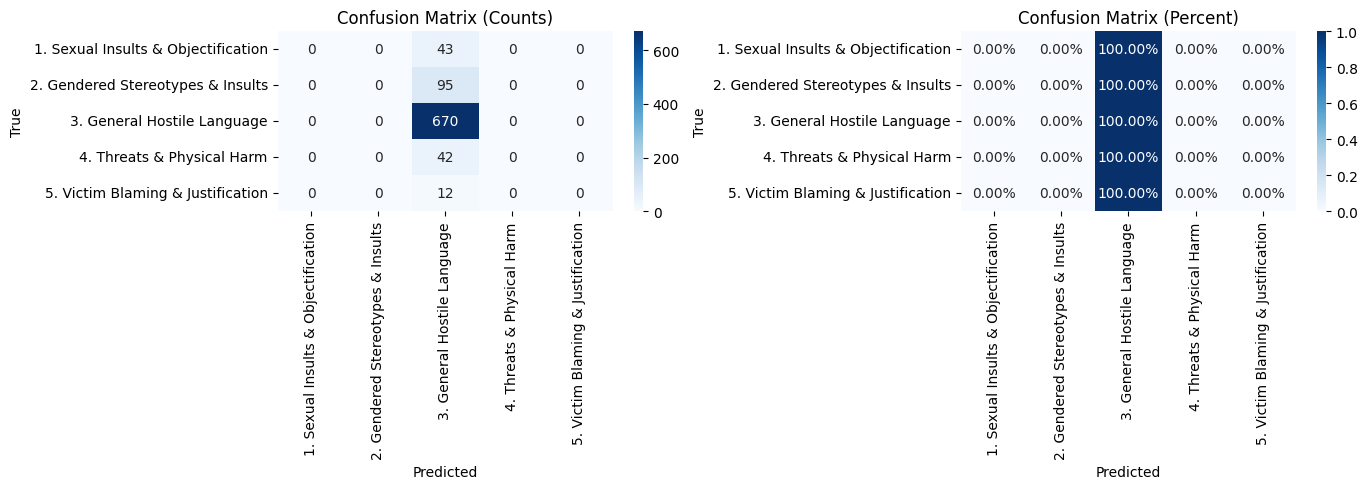

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, preds)
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_, ax=ax[0])
ax[0].set_title("Confusion Matrix (Counts)")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")

sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_, ax=ax[1])
ax[1].set_title("Confusion Matrix (Percent)")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("True")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


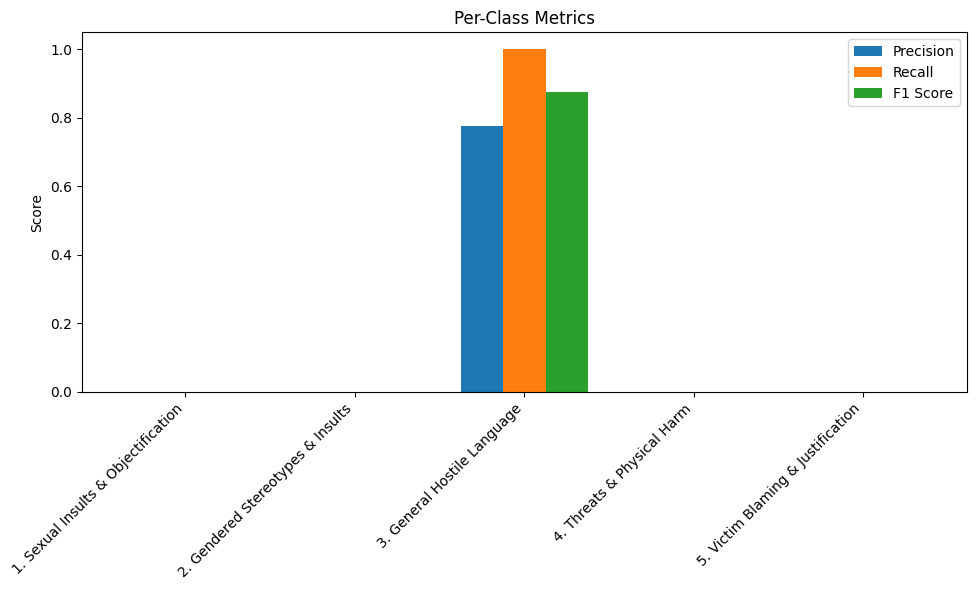

In [20]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, labels=range(len(le.classes_)))

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(le.classes_))
bar_width = 0.25

ax.bar(x, precision, bar_width, label="Precision")
ax.bar(x + bar_width, recall, bar_width, label="Recall")
ax.bar(x + 2 * bar_width, f1, bar_width, label="F1 Score")

ax.set_xticks(x + bar_width)
ax.set_xticklabels(le.classes_, rotation=45, ha="right")
ax.set_title("Per-Class Metrics")
ax.set_ylabel("Score")
ax.legend()
plt.tight_layout()
plt.show()

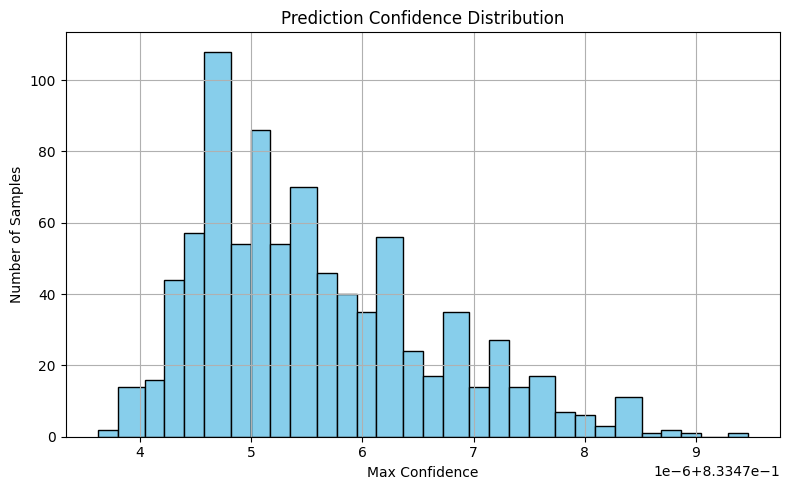

In [21]:
import torch
from torch.nn.functional import softmax

logits = torch.tensor(preds_output.predictions)
confidences = softmax(logits, dim=1)
max_confidence = confidences.max(dim=1).values.numpy()

plt.figure(figsize=(8, 5))
plt.hist(max_confidence, bins=30, edgecolor="black", color="skyblue")
plt.title("Prediction Confidence Distribution")
plt.xlabel("Max Confidence")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.tight_layout()
plt.show()

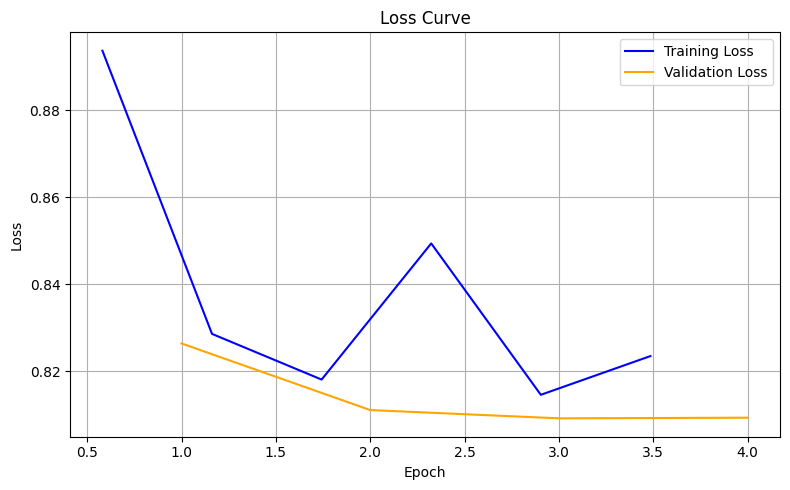

In [22]:
logs = trainer.state.log_history
df_logs = pd.DataFrame(logs)
train_loss = df_logs[df_logs["loss"].notnull()]
val_loss = df_logs[df_logs["eval_loss"].notnull()]

plt.figure(figsize=(8, 5))
plt.plot(train_loss["epoch"], train_loss["loss"], label="Training Loss", color="blue")
plt.plot(val_loss["epoch"], val_loss["eval_loss"], label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

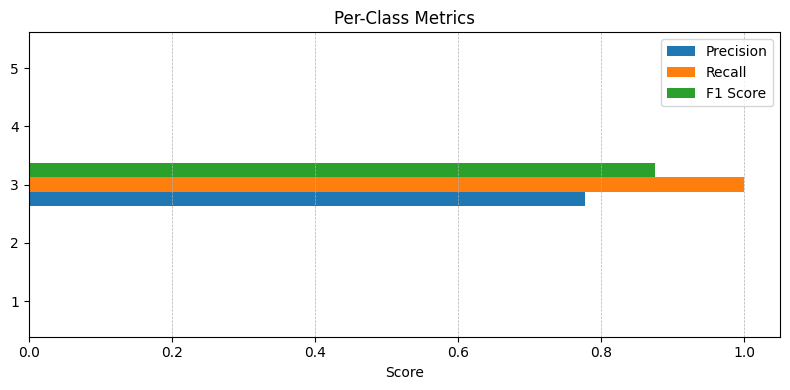

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# Example predictions and true labels
# labels = y_test (true)
# preds = model predictions
classes = ["1", "2", "3", "4", "5"]  # Replace with your real class names

precision_cls, recall_cls, f1_cls, _ = precision_recall_fscore_support(labels, preds)

fig, ax = plt.subplots(figsize=(8, 4))
bar_width = 0.25
x = np.arange(len(classes))

ax.barh(x, precision_cls, height=bar_width, label='Precision')
ax.barh(x + bar_width, recall_cls, height=bar_width, label='Recall')
ax.barh(x + 2 * bar_width, f1_cls, height=bar_width, label='F1 Score')

ax.set_yticks(x + bar_width)
ax.set_yticklabels(classes)
ax.set_xlabel("Score")
ax.set_title("Per-Class Metrics")
ax.legend()
ax.grid(True, axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

/tmp/ipython-input-24-2567940500.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette="pastel")


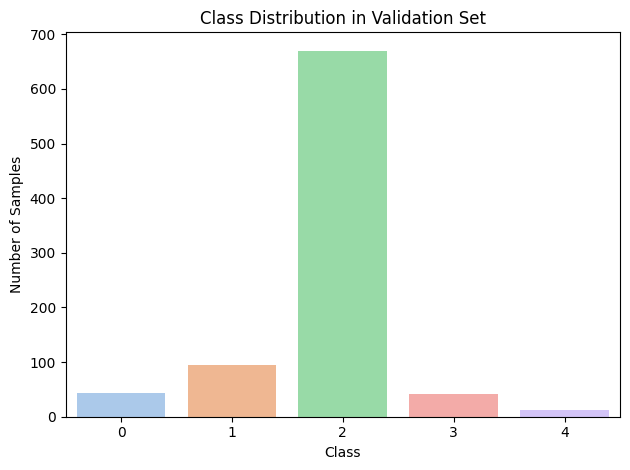

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test is a pandas Series of class labels
sns.countplot(x=y_test, palette="pastel")
plt.title("Class Distribution in Validation Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()